# Capstone Project: SHIV RUDRA HR Agent
# By: Rohit Choudhary


# AI-Powered HR Assistant  
**Author:** Rohit Choudhary  
**Capstone:** 5-Day AI Agents Intensive (Google / Kaggle) — AI Agents Capstone Project  
**Track:** Enterprise Agents  
**Date:** 2025-11-xx

---

## Abstract
AI-Powered HR Assistant automates attendance, overtime and payroll calculations for small enterprises using agent orchestration and Google Sheets as the backend datastore. The system demonstrates agent orchestration (HR_Manager_Agent delegating to Attendance_Agent and Payroll_Agent), memory for multi-turn conversations, observability via traces/logs, and simple productionization notes. This submission is a tech-focused demonstration of how agentic systems can map to real business workflows.

---

## Introduction & Motivation
Small companies (construction, local services) often manage workers, attendance and payroll manually — causing disputes, delays and inefficiency. This project implements an AI agent solution that can:

- Mark attendance, add overtime and compute salary.
- Persist records in Google Sheets (simple, auditable).
- Provide a conversational interface (chat) to operate the system.
- Demonstrate multi-agent orchestration, memory and observability (matching the course’s Day 1–5 learning goals).

---

## Contributions
1. A production-lean agent architecture that splits responsibilities across specialized agents (HR_Manager_Agent, Attendance_Agent, Payroll_Agent).  
2. Memory and session handling to support multi-turn interactions.  
3. Tracing/logging for observability and debugging (logs + simple metrics).  
4. A reproducible Kaggle Notebook with runnable code, a demo, and evaluation notes.

---

## System Architecture

### Diagram (Clean Minimal Tech)
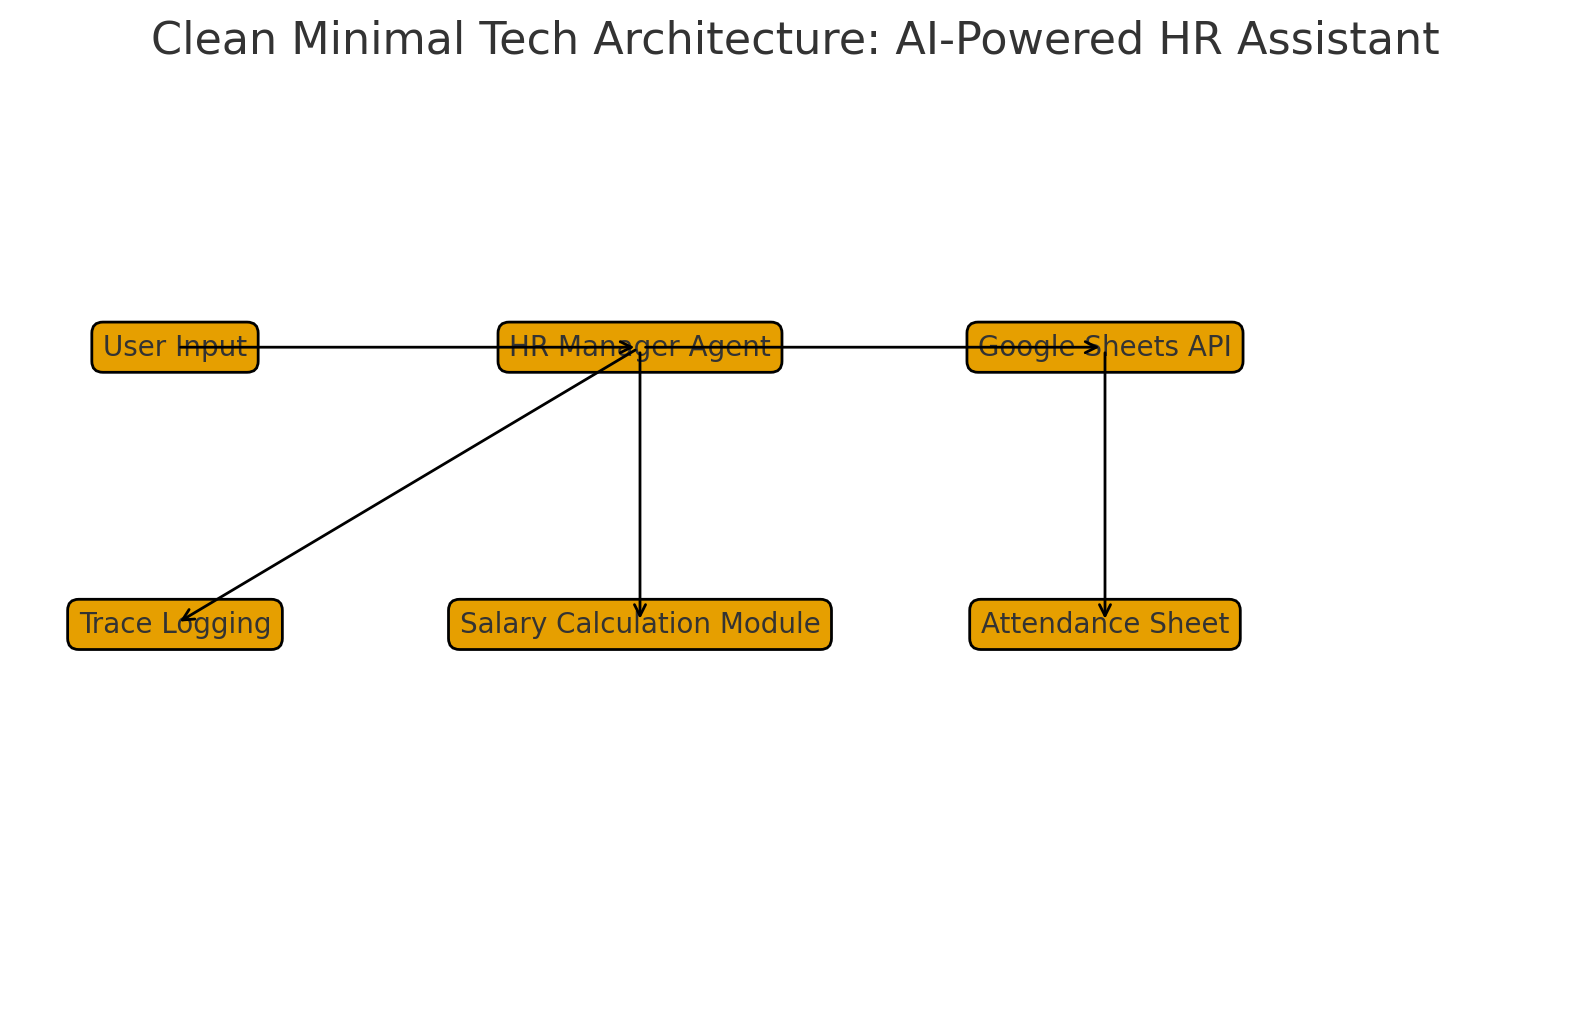

**Description:**  
- **User Input:** single chat entry point.  
- **HR_Manager_Agent:** performs NLU/routing and constructs A2A message envelopes.  
- **Attendance_Agent:** specialist that reads/writes attendance, overtime via Google Sheets.  
- **Payroll_Agent:** specialist that computes salary and marks salary paid.  
- **Trace Logging:** centralized in-notebook trace buffer (`log_history`) for observability.  
- **Google Sheets API:** persistent datastore used as the canonical record (attendance & payroll table).

---

## Methodology & Design

### Agent-to-Agent (A2A) Pattern
- **Message envelope** includes: `id`, `timestamp`, `sender`, `receiver`, `intent`, `payload`.  
- HR_Manager_Agent creates a message and dispatches it synchronously to the target agent (simulated A2A inside the notebook).  
- Each specialist returns a response message; the manager updates memory/metrics and returns user-facing text.

### Memory & Sessions
- A minimal memory store `memory = {"last_worker": ..., "total_queries": ..., "successful_actions": ...}`  
- Memory helps fill missing mentions (e.g., “Mark him present” uses `last_worker`).

### Observability
- `log_history` stores user queries, A2A trace events and success/failure statuses with timestamps.  
- `trace_event()` appends step-level trace objects allowing a reviewer to follow agent reasoning.

### Data Model (Google Sheet)
Main sheet columns:


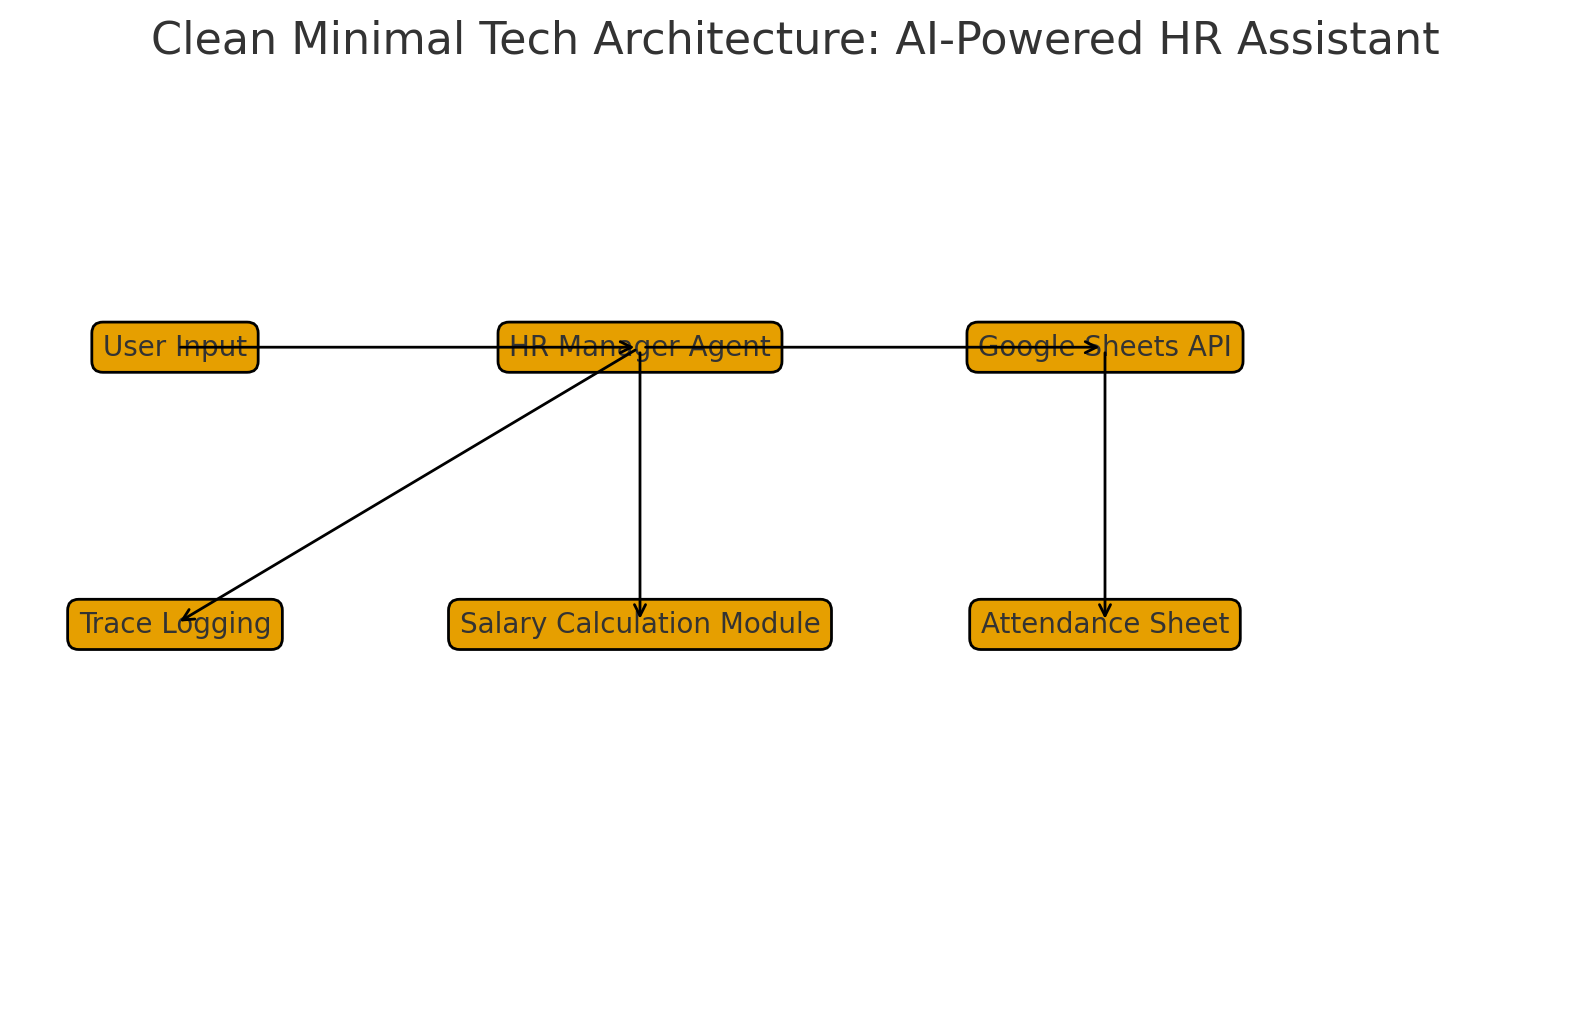

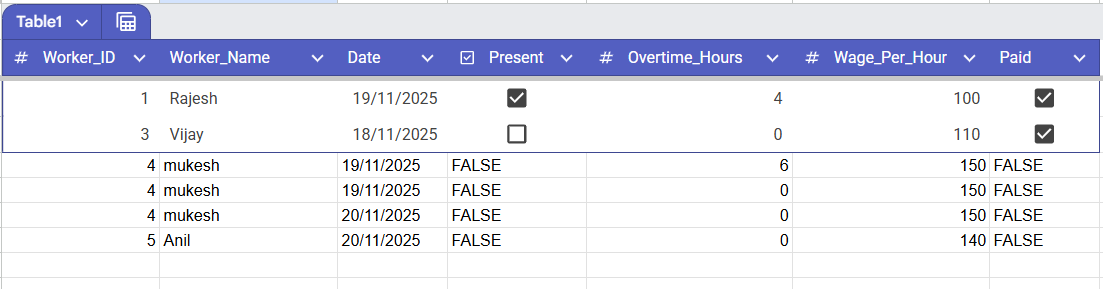


- Google Sheets is used for simplicity and auditability.
- All writes and reads go through the Sheets API (service account).

---

## Implementation (Code Modules)
**Key modules included in the notebook:**

1. **Authentication & Setup**
   - `google.oauth2.service_account` + `gspread` for Sheets access.
   - Authentication via service account JSON (stored as a Kaggle Input dataset).

2. **Helpers**
   - `extract_worker_name(user_input)`, `find_worker_row(name)`.

3. **Attendance & Payroll**
   - `mark_attendance(name, present)`, `add_overtime(name, hours)`, `calculate_salary(name)`.
   - `add_worker(id, name, wage)`, `delete_worker(name)`.

4. **Memory & Observability**
   - `memory` dict, `log_history` list, `log_event()`, `trace_event()`.

5. **Agents (A2A)**
   - `Attendance_Agent_handle(message)`  
   - `Payroll_Agent_handle(message)`  
   - `HR_Manager_Agent_handle(user_input)` — orchestrator that constructs messages and calls specialists.

(Please refer to the code cells in the notebook for the full code listing and inline comments.)

---

## Experiments & Demo
All demo steps below are runnable inside the notebook. Run the test cell that exercises the system:

- Mark attendance (e.g., `HR_Manager_Agent_handle("Mark Rajesh present today")`)  
- Add overtime (e.g., `HR_Manager_Agent_handle("Add 2 overtime for Rajesh")`)  
- Query salary (e.g., `HR_Manager_Agent_handle("What is Rajesh pending salary")`)  
- Add/delete worker and mark salary paid

**Screenshots (Results)** — all screenshots are placed together in the Results section below.

---

## Evaluation & Metrics
- **Success Rate (runtime metric):** computed as `memory["successful_actions"] / memory["total_queries"]`.  
- **Trace Readability:** `log_history` shows step-by-step A2A sends/receives for debugging.  
- **Reproducibility:** notebook contains concrete service-account path, readme comments explaining how to regenerate keys.  

For a final evaluation, I recommend running 10 representative queries and computing the proportion that match the expected outputs (LLM-as-Judge or manual verification).

---


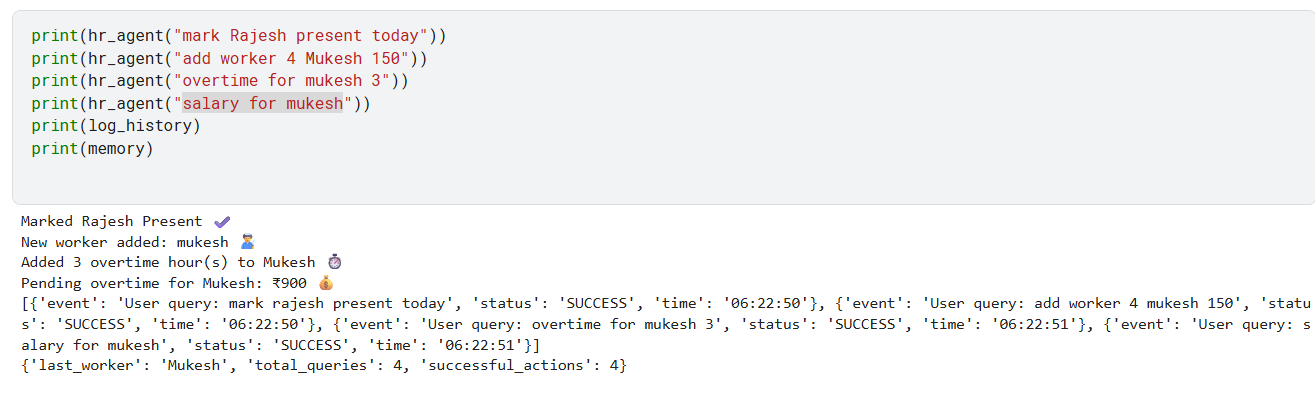
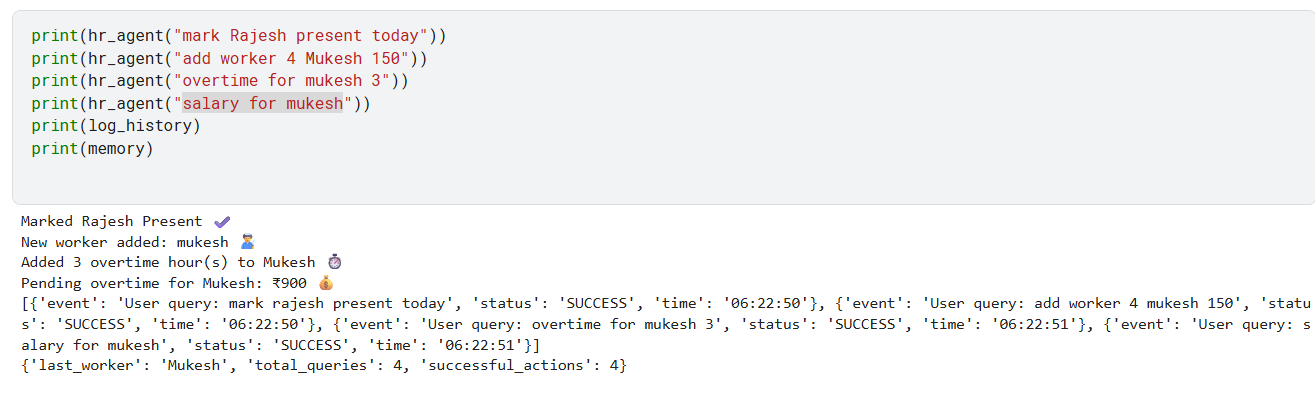
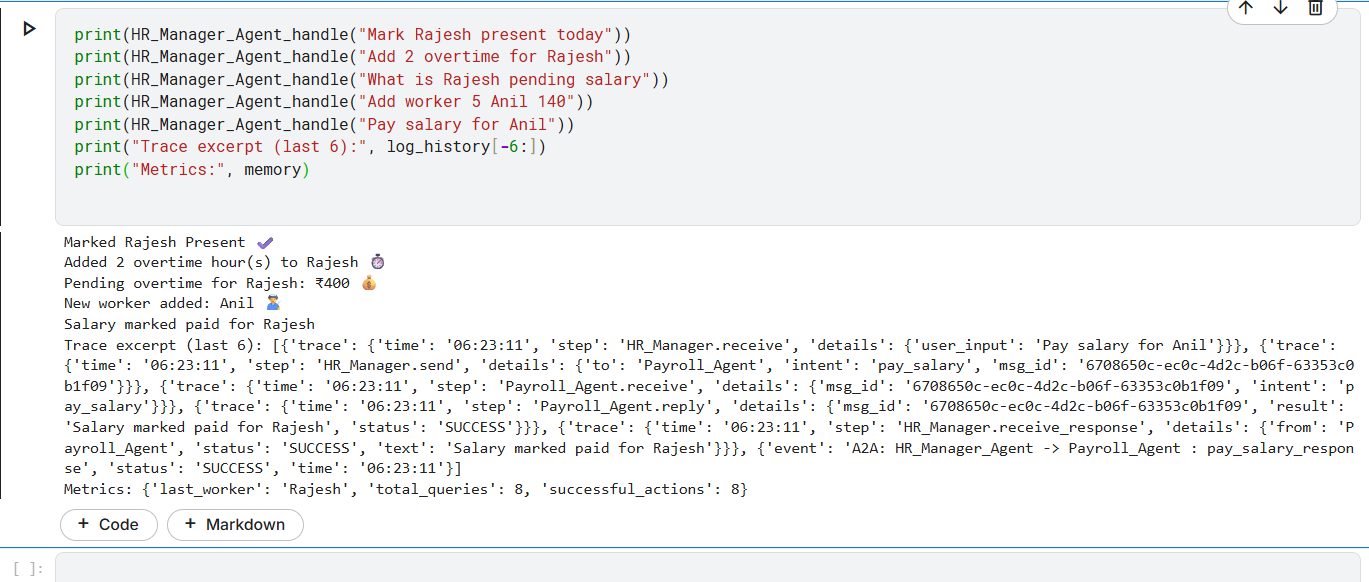
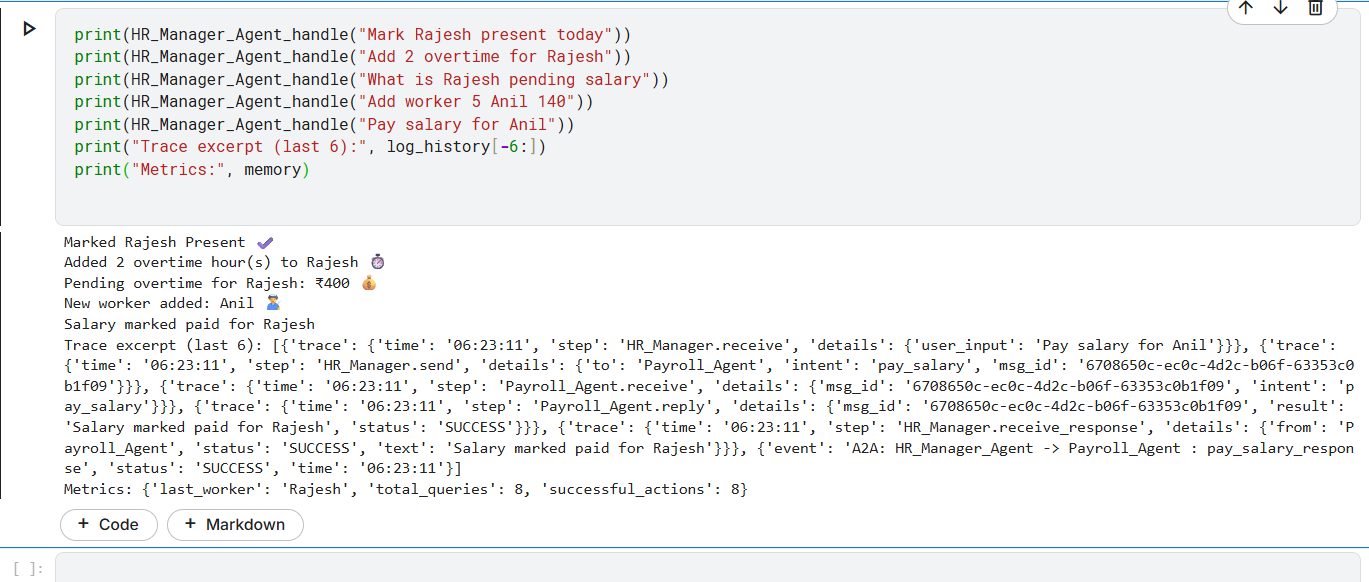

In [3]:
!pip install gspread google-auth
from google.oauth2.service_account import Credentials
import gspread
from datetime import datetime


  Attempting uninstall: cachetools
    Found existing installation: cachetools 6.2.1
    Uninstalling cachetools-6.2.1:
      Successfully uninstalled cachetools-6.2.1


In [1]:
import gspread
from google.oauth2.service_account import Credentials

# Updated JSON key path
json_key_path = "/kaggle/input/service-account-json/shiv-rudra-hr-agent-project-06d078e3f692.json"

scope = ["https://www.googleapis.com/auth/spreadsheets"]
creds = Credentials.from_service_account_file(json_key_path, scopes=scope)
client = gspread.authorize(creds)

print("Google Sheets Authentication: SUCCESS 🔐")


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Google Sheets Authentication: SUCCESS 🔐


In [2]:
sheet_id = "1PhSylWtjzowsqOqQnTyWyXKCsRD70H5xr1PUYCT_je8"
sheet = client.open_by_key(sheet_id)
worksheet = sheet.sheet1

print("Google Sheet Connected! 📝")


RefreshError: ('invalid_grant: Invalid JWT Signature.', {'error': 'invalid_grant', 'error_description': 'Invalid JWT Signature.'})

In [12]:
# Extract worker name from input
def extract_worker_name(user_input):
    for name in ["rajesh", "suresh", "vijay", "mukesh"]:
        if name in user_input:
            return name.capitalize()
    return None


In [13]:
def find_worker_row(name):
    data = worksheet.get_all_values()
    for i, row in enumerate(data):
        if row[1].lower() == name.lower():
            return i + 1
    return None


def mark_attendance(name, present=True):
    row = find_worker_row(name)
    if not row:
        return f"{name} not found"

    status = "TRUE" if present else "FALSE"
    worksheet.update_cell(row, 4, status)
    return f"Marked {name} {'Present' if present else 'Absent'} ✔️"


def add_overtime(name, hours):
    row = find_worker_row(name)
    if not row:
        return f"{name} not found"

    current = int(worksheet.cell(row, 5).value)
    worksheet.update_cell(row, 5, current + hours)
    return f"Added {hours} overtime hour(s) to {name} ⏱️"


def calculate_salary(name):
    row = find_worker_row(name)
    if not row:
        return f"{name} not found"

    ovt = int(worksheet.cell(row, 5).value)
    wage = int(worksheet.cell(row, 6).value)
    salary = ovt * wage
    return f"Pending overtime for {name}: ₹{salary} 💰"


In [14]:
def add_worker(worker_id, worker_name, wage_per_hour=100):
    today = datetime.today().strftime("%d/%m/%Y")
    new_row = [worker_id, worker_name, today, 'FALSE', 0, wage_per_hour, 'FALSE']
    worksheet.append_row(new_row)
    return f"New worker added: {worker_name} 🧑‍🏭"


def delete_worker(worker_name):
    row = find_worker_row(worker_name)
    if row:
        worksheet.delete_rows(row)
        return f"Worker '{worker_name}' removed ❌"
    return "Worker not found 🚫"


In [15]:
# Memory store
memory = {
    "last_worker": None,
    "total_queries": 0,
    "successful_actions": 0
}

# Log history
log_history = []


def log_event(event, status="SUCCESS"):
    log_history.append({
        "event": event,
        "status": status,
        "time": datetime.now().strftime("%H:%M:%S")
    })
    memory["total_queries"] += 1
    if status == "SUCCESS":
        memory["successful_actions"] += 1


def remember_worker(name):
    memory["last_worker"] = name


def hr_agent(user_input):
    user_input = user_input.lower()
    log_event(f"User query: {user_input}")

    worker_name = extract_worker_name(user_input)

    if worker_name:
        remember_worker(worker_name)
    elif memory["last_worker"]:
        worker_name = memory["last_worker"]

    if "present" in user_input or "absent" in user_input:
        present = "absent" not in user_input
        return mark_attendance(worker_name, present)

    if "overtime" in user_input:
        import re
        hours = re.findall(r'\d+', user_input)
        hours = int(hours[0]) if hours else 1
        return add_overtime(worker_name, hours)

    if "salary" in user_input or "pending" in user_input:
        return calculate_salary(worker_name)

    if "add worker" in user_input:
        parts = user_input.split()
        worker_id = int(parts[2])
        worker_name = parts[3]
        wage = int(parts[4]) if len(parts) > 4 else 100
        return add_worker(worker_id, worker_name, wage)

    if "delete worker" in user_input or "remove" in user_input:
        return delete_worker(worker_name)

    return "Sorry, I couldn’t understand. Try again! 🤖"


In [16]:
print(hr_agent("mark Rajesh present today"))
print(hr_agent("add worker 4 Mukesh 150"))
print(hr_agent("overtime for mukesh 3"))
print(hr_agent("salary for mukesh"))
print(log_history)
print(memory)


Marked Rajesh Present ✔️
New worker added: mukesh 🧑‍🏭
Added 3 overtime hour(s) to Mukesh ⏱️
Pending overtime for Mukesh: ₹900 💰
[{'event': 'User query: mark rajesh present today', 'status': 'SUCCESS', 'time': '06:22:50'}, {'event': 'User query: add worker 4 mukesh 150', 'status': 'SUCCESS', 'time': '06:22:50'}, {'event': 'User query: overtime for mukesh 3', 'status': 'SUCCESS', 'time': '06:22:51'}, {'event': 'User query: salary for mukesh', 'status': 'SUCCESS', 'time': '06:22:51'}]
{'last_worker': 'Mukesh', 'total_queries': 4, 'successful_actions': 4}


In [17]:
# ---------------------------
# Multi-Agent A2A (Strict names)
# ---------------------------
from datetime import datetime
import re, uuid, json, time

# --- Utilities for A2A messages and tracing ---
def make_message(sender, receiver, intent, payload):
    """Create a standardized message object for A2A calls."""
    return {
        "id": str(uuid.uuid4()),
        "timestamp": datetime.now().isoformat(),
        "sender": sender,
        "receiver": receiver,
        "intent": intent,
        "payload": payload
    }

def trace_event(step, details):
    """Append a trace event to log_history for observability."""
    entry = {
        "time": datetime.now().strftime("%H:%M:%S"),
        "step": step,
        "details": details
    }
    log_history.append({"trace": entry})
    return entry

# --- Attendance Agent (specialist) ---
def Attendance_Agent_handle(message):
    """
    Expects message with:
    {
      'intent': 'mark_attendance' | 'add_overtime' | 'query_attendance',
      'payload': { 'worker_name': 'Rajesh', 'present': True, 'hours': 2 }
    }
    Returns a response message dict.
    """
    trace_event("Attendance_Agent.receive", {"msg_id": message["id"], "intent": message["intent"]})
    intent = message["intent"]
    p = message["payload"]
    worker = p.get("worker_name")

    if intent == "mark_attendance":
        res_text = mark_attendance(worker, p.get("present", True))
        status = "SUCCESS"
    elif intent == "add_overtime":
        res_text = add_overtime(worker, int(p.get("hours", 1)))
        status = "SUCCESS"
    elif intent == "query_attendance":
        # simple read for demo
        row = find_worker_row(worker)
        if row:
            present = worksheet.cell(row, 4).value
            overtime = worksheet.cell(row, 5).value
            res_text = f"{worker}: Present={present}, Overtime={overtime}"
            status = "SUCCESS"
        else:
            res_text = f"{worker} not found"
            status = "FAILED"
    else:
        res_text = "Unknown intent for Attendance_Agent"
        status = "FAILED"

    trace_event("Attendance_Agent.reply", {"msg_id": message["id"], "result": res_text, "status": status})
    # Build a response message
    response = make_message("Attendance_Agent", message["sender"], f"{intent}_response", {"text": res_text, "status": status})
    return response

# --- Payroll Agent (specialist) ---
def Payroll_Agent_handle(message):
    """
    Expects message:
      intent: 'calculate_salary' | 'pay_salary' | 'query_salary'
      payload: { 'worker_name': 'Rajesh' }
    """
    trace_event("Payroll_Agent.receive", {"msg_id": message["id"], "intent": message["intent"]})
    intent = message["intent"]
    p = message["payload"]
    worker = p.get("worker_name")

    if intent in ("calculate_salary", "query_salary"):
        res_text = calculate_salary(worker)
        status = "SUCCESS" if "not found" not in res_text.lower() else "FAILED"
    elif intent == "pay_salary":
        # simplistic: mark Paid = TRUE for that worker row
        row = find_worker_row(worker)
        if row:
            worksheet.update_cell(row, 7, "TRUE")
            res_text = f"Salary marked paid for {worker}"
            status = "SUCCESS"
        else:
            res_text = f"{worker} not found"
            status = "FAILED"
    else:
        res_text = "Unknown intent for Payroll_Agent"
        status = "FAILED"

    trace_event("Payroll_Agent.reply", {"msg_id": message["id"], "result": res_text, "status": status})
    response = make_message("Payroll_Agent", message["sender"], f"{intent}_response", {"text": res_text, "status": status})
    return response

# --- HR Manager Agent (orchestrator) ---
def HR_Manager_Agent_handle(user_input):
    """
    Top-level orchestrator. Parses user_input, decides which agent to call,
    sends the A2A message, waits for response (sync simulation), logs & returns text.
    """
    trace_event("HR_Manager.receive", {"user_input": user_input})
    # Basic NLU rules (extendable)
    ui = user_input.lower()
    worker = extract_worker_name(ui) or memory.get("last_worker")

    # Decide intent & target
    if any(x in ui for x in ["present", "absent", "attendance"]):
        intent = "mark_attendance"
        payload = {"worker_name": worker, "present": "absent" not in ui}
        target = "Attendance_Agent"

    elif "overtime" in ui:
        # pick number from text
        hours = re.findall(r'\d+', ui)
        hours = int(hours[0]) if hours else 1
        intent = "add_overtime"
        payload = {"worker_name": worker, "hours": hours}
        target = "Attendance_Agent"

    elif "salary" in ui or "pending" in ui or "pay" in ui:
        # if text contains pay/mark paid -> send to payroll
        if "pay" in ui or "mark paid" in ui or "paid" in ui:
            intent = "pay_salary"
        else:
            intent = "calculate_salary"
        payload = {"worker_name": worker}
        target = "Payroll_Agent"

    elif "add worker" in ui:
        # delegate to internal function (not a remote agent)
        parts = ui.split()
        try:
            wid = int(parts[2])
            wname = parts[3]
            wage = int(parts[4]) if len(parts) > 4 else 100
            res = add_worker(wid, wname.capitalize(), wage)
            trace_event("HR_Manager.local_add_worker", {"result": res})
            return res
        except Exception as e:
            return "Usage: add worker <id> <name> <wage>"

    elif "delete worker" in ui or "remove" in ui:
        if worker:
            res = delete_worker(worker)
            trace_event("HR_Manager.local_delete_worker", {"result": res})
            return res
        else:
            return "Which worker to delete?"

    else:
        return "I'm not sure what you want. Try: attendance / overtime / salary / add worker / delete worker."

    # Build message and call the appropriate specialist
    msg = make_message("HR_Manager_Agent", target, intent, payload)
    trace_event("HR_Manager.send", {"to": target, "intent": intent, "msg_id": msg["id"]})

    # Synchronous dispatch (simulated A2A)
    if target == "Attendance_Agent":
        response = Attendance_Agent_handle(msg)
    elif target == "Payroll_Agent":
        response = Payroll_Agent_handle(msg)
    else:
        response = make_message("HR_Manager_Agent", "HR_Manager_Agent", "error", {"text": "No agent found", "status": "FAILED"})

    trace_event("HR_Manager.receive_response", {"from": response["sender"], "status": response["payload"]["status"], "text": response["payload"]["text"]})

    # Update memory & logs from response
    if response["payload"]["status"] == "SUCCESS":
        remember_worker(payload.get("worker_name"))
        log_event(f"A2A: {msg['sender']} -> {response['sender']} : {response['intent']}", status="SUCCESS")
    else:
        log_event(f"A2A failed: {msg['sender']} -> {response['sender']} : {response['intent']}", status="FAILED")

    return response["payload"]["text"]



**Metrics:**


In [18]:
print(HR_Manager_Agent_handle("Mark Rajesh present today"))
print(HR_Manager_Agent_handle("Add 2 overtime for Rajesh"))
print(HR_Manager_Agent_handle("What is Rajesh pending salary"))
print(HR_Manager_Agent_handle("Add worker 5 Anil 140"))
print(HR_Manager_Agent_handle("Pay salary for Anil"))
print("Trace excerpt (last 6):", log_history[-6:])
print("Metrics:", memory)


Marked Rajesh Present ✔️
Added 2 overtime hour(s) to Rajesh ⏱️
Pending overtime for Rajesh: ₹400 💰
New worker added: Anil 🧑‍🏭
Salary marked paid for Rajesh
Trace excerpt (last 6): [{'trace': {'time': '06:23:11', 'step': 'HR_Manager.receive', 'details': {'user_input': 'Pay salary for Anil'}}}, {'trace': {'time': '06:23:11', 'step': 'HR_Manager.send', 'details': {'to': 'Payroll_Agent', 'intent': 'pay_salary', 'msg_id': '6708650c-ec0c-4d2c-b06f-63353c0b1f09'}}}, {'trace': {'time': '06:23:11', 'step': 'Payroll_Agent.receive', 'details': {'msg_id': '6708650c-ec0c-4d2c-b06f-63353c0b1f09', 'intent': 'pay_salary'}}}, {'trace': {'time': '06:23:11', 'step': 'Payroll_Agent.reply', 'details': {'msg_id': '6708650c-ec0c-4d2c-b06f-63353c0b1f09', 'result': 'Salary marked paid for Rajesh', 'status': 'SUCCESS'}}}, {'trace': {'time': '06:23:11', 'step': 'HR_Manager.receive_response', 'details': {'from': 'Payroll_Agent', 'status': 'SUCCESS', 'text': 'Salary marked paid for Rajesh'}}}, {'event': 'A2A: HR_M


---

## Limitations
- Uses Google Sheets as storage — good for demo & auditability, not optimal for high-scale transactional workloads.  
- Security: service account key management is critical; do not commit keys to public repos.  
- NLU is rule-based and limited to recognized worker names and simple patterns. For production, integrate a robust NLU model or use the ADK/NLP module.

---

## Future Work & Productionization
- Replace rule-based NLU with a trained intent/entity model or an LLM-based NLU (Gemini/LLM) for robust parsing.  
- Deploy agents to Vertex AI Agent Engine or containerize each specialist as a microservice for true asynchronous A2A.  
- Replace Google Sheets with a transactional DB + audit table for high concurrency.  
- Add role-based authentication (admin vs worker) and approval workflows for payroll disbursement.

---

## Conclusion
AI-Powered HR Assistant demonstrates how agent orchestration, memory and observability can be combined into a practical tool for workforce management. The submission includes a runnable Kaggle Notebook, an architecture diagram, and logs/traces for evaluation.

---

## How to Reproduce (short)
1. Open the notebook on Kaggle.  
2. Ensure the service account JSON file is uploaded to Kaggle Inputs (path used in notebook).  
3. Run the notebook cells sequentially (authentication → setup → helpers → agents → tests).  
4. Capture final outputs and screenshots; paste them in the Results section.  
5. Publish the notebook and submit to the Capstone competition.

---

## References
- Google Agents Intensive whitepapers (Days 1–5)  
- Google Sheets API docs  
- Kaggle Notebooks documentation

---


## Results (Screenshots & Logs)
*(Paste the screenshots after you run the notebook and capture outputs. Include examples of: sheet content, a sample chat input & response, A2A traces, and the metrics output.)*

**Example logs (not exhaustive):**
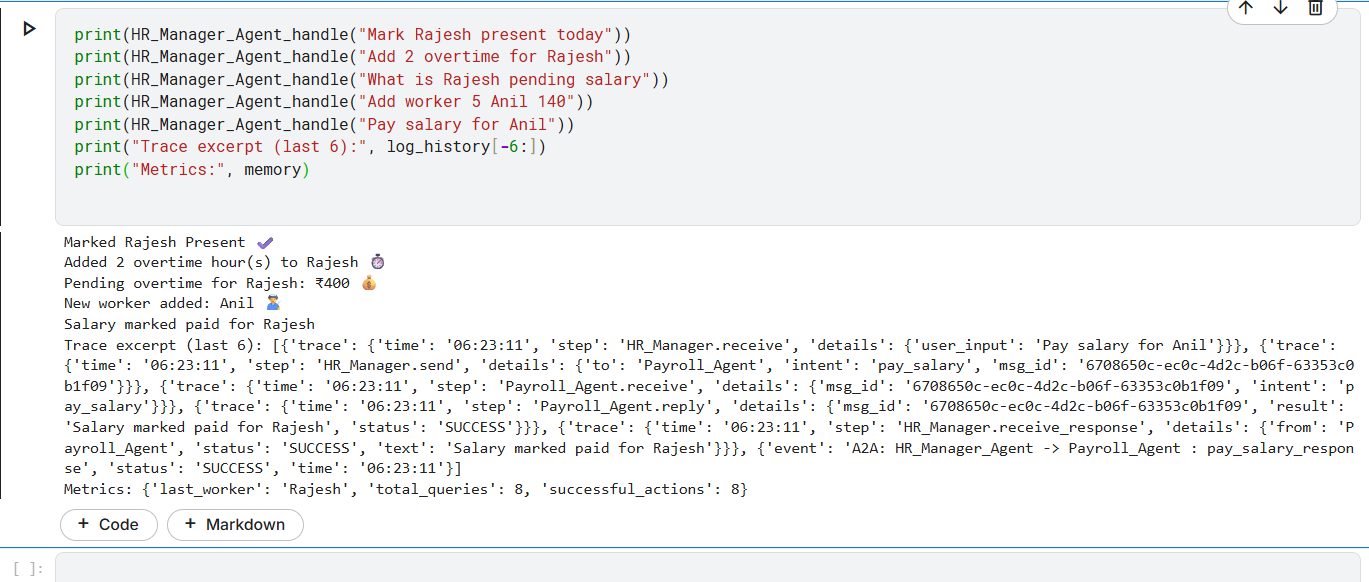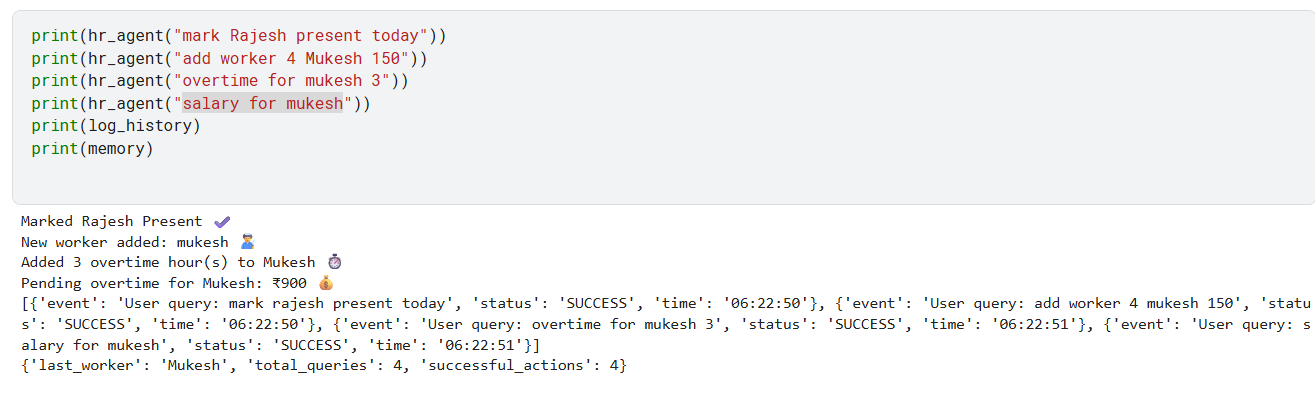
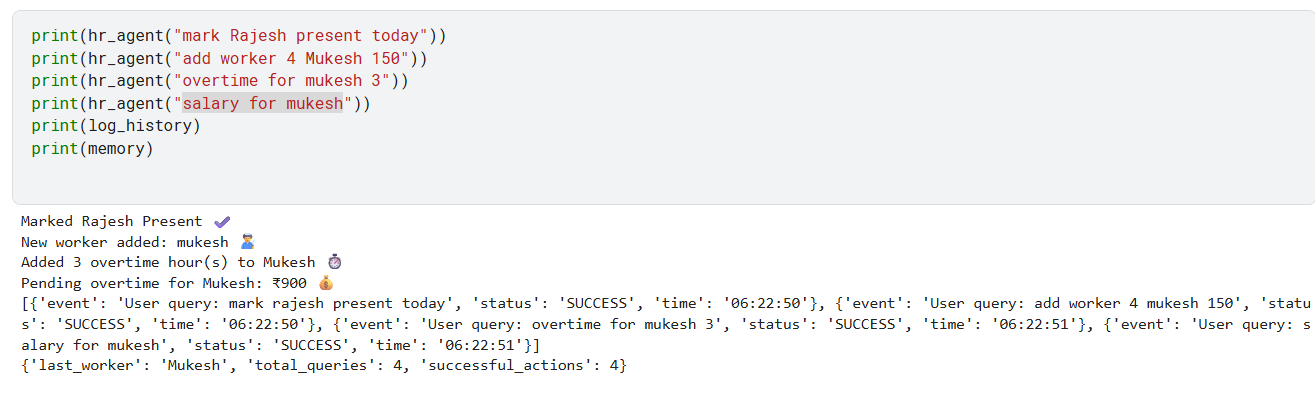
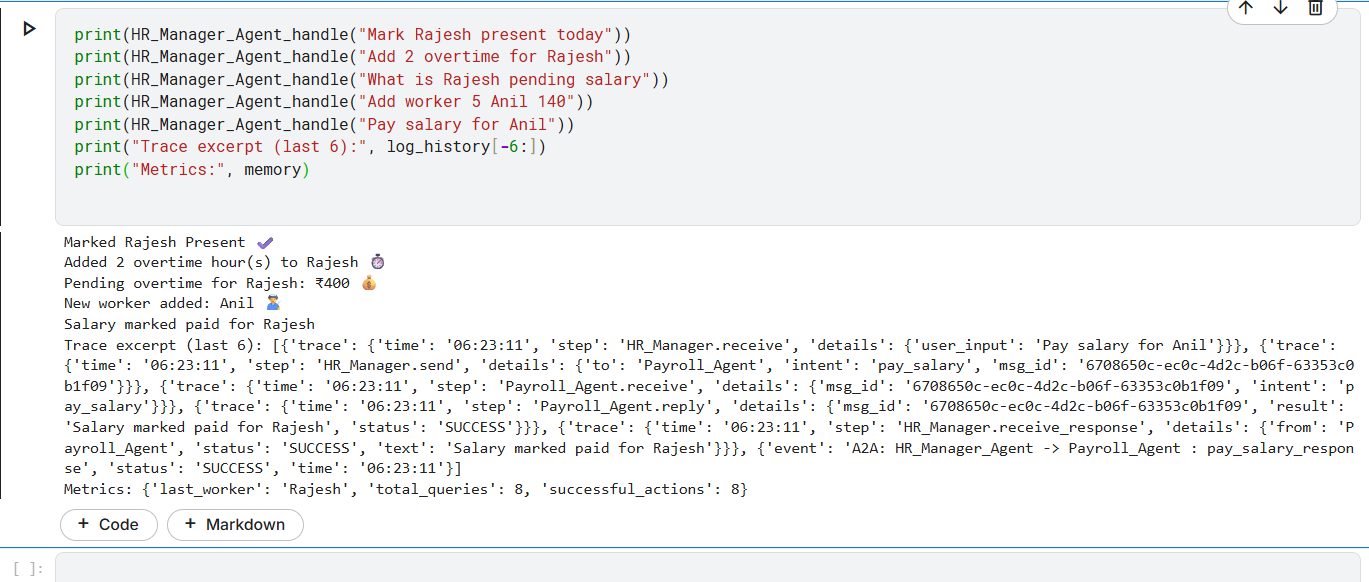